 The goal of this project is to predict if a passenger on the Titanic will survive based on a number of variables. For instance, their sex, age, ticket class, fare, whether they had siblings or parents onboard and their cabin number. Of course, we also know whether each passenger survived or not. We also mention a 38% survival rate.
 
 We import the required libraries.

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Next, we prepare data, read in input data files into their respective pandas dataframes. We have a training data set to train our model and a test dataset which will be used to validate our dataset. This can also be accomplished if one splits the training data up and reserves a portion of it for later.

In [68]:
train_df = pd.read_csv('C:/Users/Dell/Documents/train.csv')
test_df = pd.read_csv('C:/Users/Dell/Documents/test.csv')
combine_df = [train_df, test_df]

Lets have a look at the data to see what we're working with

In [69]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


At this stage, we'd like to get to know the data a bit better. For example, What type is each variable? How complete is the data? At that point, we'll be in a better position to perform the proper data munging and know which ML models are most likely to give the best results. Pandas has some handy tools to have a first look at the data very easily.

train_df.info()
print('_'*40)
test_df.info()

In [70]:
# This will perform basic statistics on numerical values only
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In our project description, we have taken the survival rate as the 38%. It looks like we have some incomplete values for Age (714 non-null values of a total 891) and Cabin (only 204 non-null values)

In [71]:
# to find the number of unique values for each feature
train_df.nunique()
# Or use describe again with the flag to include 0's and hence consider categorical values as well
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Byles, Rev. Thomas Roussel Davids",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


At this point, we implement the "5Cs" before proceeding further into the analysis -
Correlation, Completing, Correcting, Creating, Classifying.

First, we perform some exploratory analysis of various features against survival to see how well they are correlated. The features below are selected as they are complete, categorical/discretely valued.

In [72]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [73]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [74]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [75]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Now, we perform some Data Visualisation tasks to investigate a bit further, using histograms. We plot the numerical features vs. survival We will use the Seaborn package (FacetGrid)

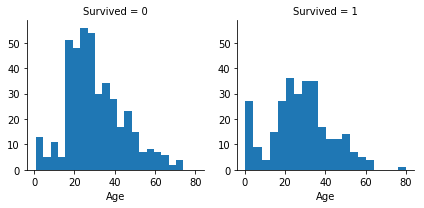

In [76]:
# use a facetgrid (FacetGrid is used to draw plots with multiple Axes 
# where each Axes shows the same relationship conditioned on different levels of some variable.

%matplotlib inline

g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)


Observations: 

-Young Children had a high survival rate (>20%)

-Many 15-25 year olds did not survive.

-Majority of passengers are in the 15-35 age range.

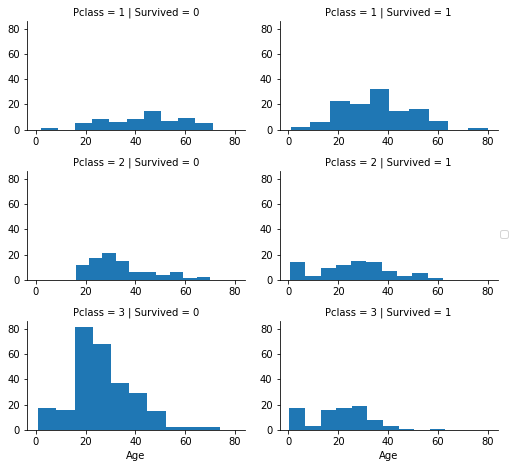

In [77]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6 )
grid.map(plt.hist, 'Age')
grid.add_legend()

Observations:

Pclass=3 had the most passengers but most of them did not survive.
The youngest passengers (ie less than 5) in Pclass=2 and Pclass=3 mostly survived.
Most passengers in Pclass=1 survived. Pclass varies in terms of Age distribution of passengers.

Based on these observations, Pclass is good to consider for model training









Now we will correlate the categorical features
We will examine the sex of the passenger, the class and where they embarked with survival. We will use line/point plots on the same facetgrid for each embarkation point.

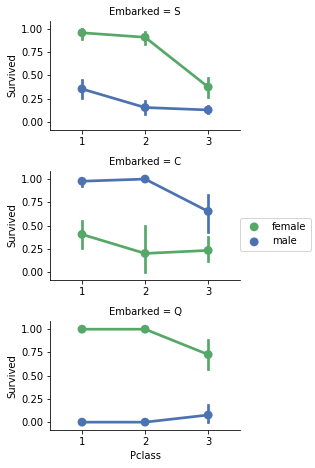

In [78]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Observations:

PClass 1 and 2 generally had higher survival rates

Females in 2 of the 3 embarkment points had significantly higher survival rates than males. A similar pattern is observed for the other embarkment point for males (C)

Point of embarkment does have a varying effect on survival for males.

Based on this, Embarked and Sex will be added to model training. Embarked has 889 non null values so the remaining two will need to be completed.

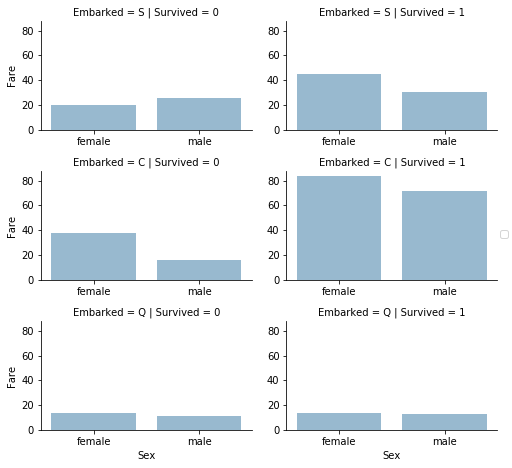

In [79]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived',size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=0.5, ci=None)
grid.add_legend()

Observations: 

Embarkment point affects survival

Again, in general females have higher survival rate

Higher paying passengers had higher survival rate

Moving forward, we bin our Fare data in order to see more meaningful trends in different fare classes.

In [80]:
train_df['Fare']

0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
5        8.4583
6       51.8625
7       21.0750
8       11.1333
9       30.0708
10      16.7000
11      26.5500
12       8.0500
13      31.2750
14       7.8542
15      16.0000
16      29.1250
17      13.0000
18      18.0000
19       7.2250
20      26.0000
21      13.0000
22       8.0292
23      35.5000
24      21.0750
25      31.3875
26       7.2250
27     263.0000
28       7.8792
29       7.8958
         ...   
861     11.5000
862     25.9292
863     69.5500
864     13.0000
865     13.0000
866     13.8583
867     50.4958
868      9.5000
869     11.1333
870      7.8958
871     52.5542
872      5.0000
873      9.0000
874     24.0000
875      7.2250
876      9.8458
877      7.8958
878      7.8958
879     83.1583
880     26.0000
881      7.8958
882     10.5167
883     10.5000
884      7.0500
885     29.1250
886     13.0000
887     30.0000
888     23.4500
889     30.0000
890      7.7500
Name: Fare, Length: 891,

We now have a better idea of what features have a strong impact on survival and those that don't. Also, we have some idea of how to combine our existing features to possibly give a single feature that is more meaningful.

Now we do some Data Wrangling. We drop Cabin and Ticket features as they're not necessary features to predict survival. These should be done on both training and test data sets.

In [81]:
print("Before", train_df.shape, test_df.shape, combine_df[0].shape, combine_df[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine_df = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine_df[0].shape, combine_df[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


In [82]:
# iterate over both datasets in combine (train_df and test_df)
# and note that we also added the new field to both datasets

for dataset in combine_df:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])


#print("After", train_df.shape, test_df.shape, combine_df[0].shape, combine_df[1].shape)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [83]:
for dataset in combine_df:
    # these titles are interesting, but very few numbers of them exist, hence 'Rare'
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Rare titles had an about average rate of survival Miss, Mrs, Master (children) had much higher rates of survival Mr had the poorest survival

To simplify this will be converted to ordinal values.

In [84]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine_df:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
   
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [85]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine_df = [train_df, test_df]

train_df.shape, test_df.shape

#train_df.head()
#test_df.head()

((891, 9), (418, 9))

Most models require numerical inputs rather than strings. Thus, the categorical features also should be represented numerically, as we did above with Title. Here the 'Sex' feature has been replaced with numerical representation of 1-> female and 0-> male

In [86]:
for dataset in combine_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


Completing a numerical continuous feature:

As seen above, the Age feature contains null values. To complete it, Guess an age based on correlations with other feature. For example, a correlation between Gender and Pclass. Use the median age value for a given Gneder, Pclass.

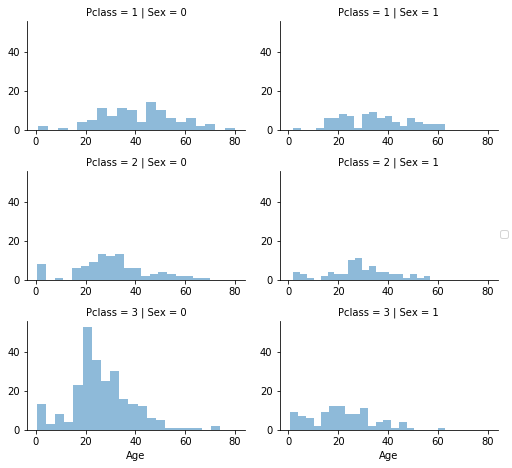

In [87]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend()

In [88]:
guess_ages = np.zeros((2,3))
guess_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [89]:
for dataset in combine_df:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
           
            age_guess = guess_df.median()
            #print(age_guess)
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            #print(guess_ages)
            #print('-'*10)
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),
                        'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)   

train_df.head(20) 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1
5,0,3,0,25,0,0,8.4583,Q,1
6,0,1,0,54,0,0,51.8625,S,1
7,0,3,0,2,3,1,21.0750,S,4
8,1,3,1,27,0,2,11.1333,S,3
9,1,2,1,14,1,0,30.0708,C,3


No more null values in age! They have been replaced with the median value for each specific gender, pclass.

In [90]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [91]:
# ages converted into ordinal values
for dataset in combine_df:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[  dataset['Age'] > 64, 'Age'] = 4

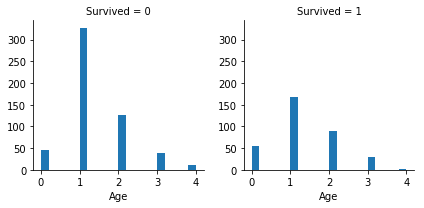

In [92]:
grid = sns.FacetGrid(train_df, col='Survived')
grid.map(plt.hist, 'Age', bins=20)

In [93]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine_df = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


Create new features by combining existing features:
    
We can boil down the Parch and Sibsp features into something that captures both. We'll combine these to create a FamilySize feature.

In [94]:
for dataset in combine_df:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [95]:
# isAlone feature added
for dataset in combine_df:
    dataset['isAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'isAlone'] = 1 #set isAlone to False if family 

train_df[['isAlone', 'Survived']].groupby(['isAlone'], as_index=False).mean()    

,isAlone,Survived
0,0,0.505650
1,1,0.303538


In [96]:
#we drop a few features and focus on isAlone for further analysis
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

combine_df = [train_df, test_df]

# error shown as already dropped values in the first run
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [97]:
for dataset in combine_df:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    
train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


Complete categorical feature:

The embarked feature has values of S,Q, and C. Two values are missing, so these can jsut be replaced with the most commonly occurring point of embarkation (use the mode).

In [98]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [99]:
# use freq_port in the the fillna function
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Convert categorical to numeric:

We will also replace the port with numerical values. we will use a dict and with the ports as key map the values to each.

In [100]:
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


Complete and convert a numeric feature:

The fare value is also incomplete, and we will replace it using the most frequently occurring value (the mode). 

In [101]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [102]:
train_df['Fare'].fillna(train_df['Fare'].dropna().median(), inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


Again, we will use pandas qcut function to separate the fare into bands. Note that qcut ensures that each band has approximately the same number of values where cut separates the range of the data by the number of bins specified.

In [103]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

#train_df['FareBand'].value_counts()

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [104]:
for dataset in combine_df:
    dataset.loc[ dataset['Fare'] <=7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.454), 'Fare' ] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <=31), 'Fare' ] = 2
    dataset.loc[ (dataset['Fare'] > 31), 'Fare' ] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)


train_df = train_df.drop(['FareBand'], axis=1)

In [105]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [106]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


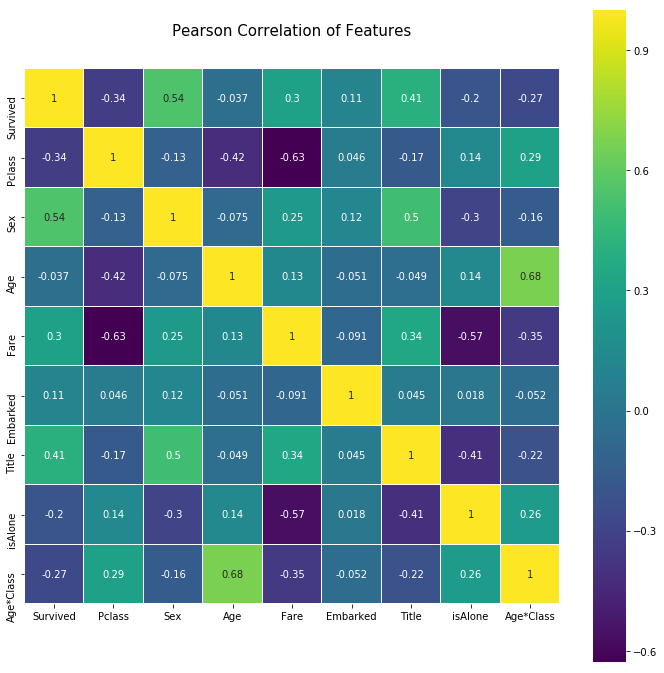

In [107]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Model, Predict and Solve:

The dataset is now ready to be used as training data for a model and predict a solution. We need to understand what type of problem we are working with and then implement the best predictive models for this particular case.

Since we already know the results, this is a supervised learning problem
We are trying to classify whether someone survived (1 or 0) based on input variables (regression).
The suggested models for this case are:

1. Logistic Regression

2. KNN or k-Nearest Neighbors

3. Naive Bayes classifier

4. Decision Tree 

To begin, we will separate the Survived feature from our training data, as this is what we will try to predict and ensure that the training and test data contain the same features.

In [108]:
X_train = train_df.drop('Survived', axis=1) # independent variables only
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

Logistic Regression:

Logistic Regression is used for cases where the dependent variable or outcome is categorical. In this case, this means that it can be represented by a binary outcome such as pass/fail, win/lose, or in this case, survived/not survived. Logistic regression measures the relationship between the dependent variable and one or more independent variables with estimated probabilities.

In [109]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

81.260000000000005

In [110]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.200978
5,Title,0.414362
4,Embarked,0.281026
6,isAlone,0.262084
3,Fare,-0.022062
7,Age*Class,-0.085959
2,Age,-0.371647
0,Pclass,-1.083515


k-Nearest Neighbours (k-NN):

This is a non parametric method used for classification and regression. The model would predict the value for the dependent variable that it is closest to its similar neighbours in the feature space.

In [111]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn


84.060000000000002

Naive Bayes:

Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. Naive Bayes classifiers are highly scalable and well suited to large datasets.

In [112]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.879999999999995

Decision Tree:

Decision tree learning uses a decision tree to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). (wikipedia).

In [113]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.640000000000001

In [114]:
# Now to submit prediction
results = Y_pred
results = pd.Series(results,name="Survived")
results=results.astype(int)
test_df = pd.read_csv('C:/Users/Dell/Documents/test.csv')
passengerid = test_df['PassengerId'].astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df['PassengerId'],
        "Survived": results
    })


submission.to_csv("random_forest.csv",index=False)
